In [1]:
import someip_timing_analysis.analysis as analysis
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from someip_timing_analysis.entities import *
from someip_timing_analysis.graph import *
from typing import List

In [2]:
# Set the logging level.
analysis.set_logger_level(analysis.logging.ERROR)

# Network Support

In [3]:
class Device(Node):
    """The device extends node from the G library.
    """
    def __init__(self, id: int, entities: List[Entity], base_delay: float = 0):
        """It takes as input the unique id, and the list of entities.
        Args:
            id (int): The unique id.
            entities (List[Entity]): The list of entities.
            base_delay (_type_, optional): Base software delay. Defaults to 0.
        """
        Node.__init__(self, id)
        self.entities: List[Entity] = entities
        self.base_delay = base_delay

    def device_delay(self) -> float:
        return len(self.entities) * self.base_delay

def device_to_device_delay(G: Graph, source: Device, target: Device) -> float:
    """Get the delay between every node in MILLISECONDS.

    Args:
        source (Device): Source device.
        target (Device): Target device.

    Returns:
        float: The delay between the nodes.
    """
    if source == target:
        return 0
    # Find the path with the lowest delay.
    (delay, _) = G.find_shortest_path(source, target)
    # Compute the total delay.
    return source.device_delay() + delay + target.device_delay()


# Scenario (SOME/IP)

In [4]:
# Load the services.
S0 = Service("S0", boot_del=2, init_del=4, rep_del=1, rep_max=3, cyc_del=2, ans_del=1, offer_mode=True)
S1 = Service("S1", boot_del=1, init_del=3, rep_del=1, rep_max=3, cyc_del=2, ans_del=1, offer_mode=True)
S2 = Service("S2", boot_del=4, init_del=6, rep_del=1, rep_max=3, cyc_del=2, ans_del=1, offer_mode=True)
S3 = Service("S3", boot_del=2, init_del=4, rep_del=1, rep_max=3, cyc_del=2, ans_del=1, offer_mode=True)
S4 = Service("S4", boot_del=1, init_del=3, rep_del=1, rep_max=3, cyc_del=2, ans_del=1, offer_mode=True)

# Load the clients.
C0 = Client("C0", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)
C1 = Client("C1", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)
C2 = Client("C2", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)
C3 = Client("C3", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)
C4 = Client("C4", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)
C5 = Client("C5", boot_del=3, init_del=2, rep_del=1, rep_max=3, find_mode=True)


# Scenario (Graph)

In [5]:
# Place services and clients inside nodes.
n0 = Device(id = 0, entities = [S0, C0, C1], base_delay =  5e-06)
n1 = Device(id = 1, entities = [S1, S2],     base_delay = 25e-06)
n2 = Device(id = 2, entities = [S3, C2, C3], base_delay = 75e-06)
n3 = Device(id = 3, entities = [S4, C4],     base_delay = 45e-06)
n4 = Device(id = 4, entities = [C5],         base_delay = 76e-06)

# Create the G, using weights computed using the following formula:
#   (frame_length * 8) / link_speed
# 
graph = Graph(
    connections = [
        (n0, n1, lambda G, node0, node1: ( 256 * 8) / 1e09),
        (n1, n2, lambda G, node0, node1: ( 256 * 8) / 1e09),
        (n1, n3, lambda G, node0, node1: (1024 * 8) / 1e09),
        (n3, n4, lambda G, node0, node1: ( 256 * 8) / 1e09),
        (n2, n3, lambda G, node0, node1: ( 256 * 8) / 1e09),
        (n2, n4, lambda G, node0, node1: (1024 * 8) / 1e09)
    ],
    directed = False
)


# Visualize the graph

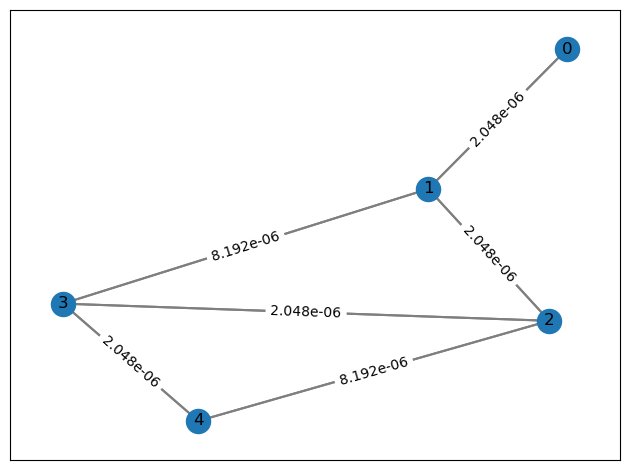

In [6]:
if graph.directed:
    G = nx.DiGraph()
else:
    G = nx.Graph()

# List of edges.
edge_list = [(source.id, target.id) for (source, target) in graph.get_edge_list()]

# List of edge labels.
edge_labels = {}
for (source, target) in graph.get_edge_list():
    edge_labels[source.id, target.id] = str(graph.get_weight(source, target))

# Add the edges.
G.add_edges_from(edge_list)
# Positions for all nodes.
pos = nx.spring_layout(G, k=1, iterations=100)
# Add the nodes.
nx.draw_networkx_nodes(G, pos, node_color="tab:blue")
# Draw the node labels.
nx.draw_networkx_labels(G, pos, font_family="sans-serif")
# Draw the edges.
nx.draw_networkx_edges(G, pos, edgelist=edge_list, width=1.5, edge_color="tab:gray")
# Draw the edges weights.
nx.draw_networkx_edge_labels(G, pos, edge_labels)
# Draw the G.
plt.tight_layout()
plt.show()

# Compute timing analysis

In [7]:
# Check where the SOME/IP entities are located.
containing_node = {}
for node in graph.graph:
    for entity in node.entities:
        containing_node[entity] = node

def create_relation(G: Graph, e0: Entity, e1: Entity) -> Relation:
    """Creates a relation between the pair of entities.

    Args:
        G (Graph): The G.
        e0 (Entity): The first entity.
        e1 (Entity): The second entity.

    Returns:
        Relation: A relation between the entities.
    """
    # Compute the device to device delay.
    delay = device_to_device_delay(G, containing_node[e0], containing_node[e1])
    # Create the relation, and transform the delay to milliseconds.
    return Relation(e0, e1, delay * 1e03)

# Define the relations between clients and services.
system = System([
    create_relation(graph, C0, S3),
    create_relation(graph, C0, S4),
    create_relation(graph, C1, S0),
    create_relation(graph, C2, S4),
    create_relation(graph, C3, S4),
    create_relation(graph, C3, S0),
    create_relation(graph, C4, S1),
    create_relation(graph, C5, S0)
])

# Compute the discovery times.
discovery_times = analysis.compute_discovery_times(system)

# Compute the worst-case discovery time.
highest_discovery_time = analysis.get_highest_discovery_time(system)

# Compute the worst-case discovery time.
highest_impact_relation = analysis.get_highest_impact_relation(system)

print("The highest discovery time is: {}".format(highest_discovery_time))
print("The highest discovery relation is: {}".format(highest_impact_relation))

The highest discovery time is: 6.244096
The highest discovery relation is: (6.244096, <C0,S3,0.24409599999999998>)


# Plot discovery times as bar graph

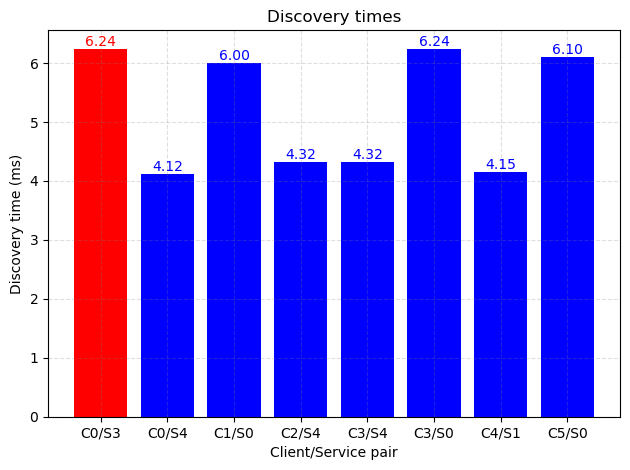

In [8]:
# Extract the x and y.
x = ["%s/%s"%(entry[1].client, entry[1].service) for entry in discovery_times]
y = [entry[0] for entry in discovery_times]
# Color in red the highest impact relation.
c = ["red" if entry[1] == highest_impact_relation[1] else "blue" for entry in discovery_times]

# Set the title.
plt.title("Discovery times")
# Set the grids.
plt.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
plt.grid(True, linestyle='-', which='minor', color='grey', alpha=.25)
# Set the labels.
plt.xlabel("Client/Service pair")
plt.ylabel("Discovery time (ms)")
# Plot the bars.
plt.bar(x, y, color=c)
# Add values.
for i, v in enumerate(y):
    plt.text(x[i], y[i], "%.2f"%(v), color=c[i], ha='center', va='bottom')
# Draw the graph.
plt.tight_layout()

# Store discovery times in pandas DataFrame

In [9]:
# Create the table.
data = [
    [str(entry[1].client), str(entry[1].service), entry[0]] for entry in discovery_times
]

# Create the pandas dataframe.
df = pd.DataFrame(data, columns=['Client', 'Service', 'Discovery Time'])

# Print the dataframe.
print(df)

  Client Service  Discovery Time
0     C0      S3        6.244096
1     C0      S4        4.115240
2     C1      S0        6.000000
3     C2      S4        4.317048
4     C3      S4        4.317048
5     C3      S0        6.244096
6     C4      S1        4.148192
7     C5      S0        6.103288


# Show discovery time full report

In [20]:
# Compute the discovery times with details.
full_report = analysis.compute_discovery_times_full_details(system)
# Print the full report.
for result in full_report:
    print(result.client, result.service, "%.2f"%result.discovery_time, result.details)

C0 S3 6.24 {'s.t_init': 6, 's.t_rep': 0.0, 's.t_cyc': 0, 't_c': 0.24409599999999998}
C0 S4 4.12 {'s.t_init': 4, 's.t_rep': 0.0, 's.t_cyc': 0, 't_c': 0.11524000000000001}
C1 S0 6.00 {'s.t_init': 6, 's.t_rep': 0.0, 's.t_cyc': 0, 't_c': 0.0}
C2 S4 4.32 {'s.t_init': 4, 's.t_rep': 0.0, 's.t_cyc': 0, 't_c': 0.317048}
C3 S4 4.32 {'s.t_init': 4, 's.t_rep': 0.0, 's.t_cyc': 0, 't_c': 0.317048}
C3 S0 6.24 {'s.t_init': 6, 's.t_rep': 0.0, 's.t_cyc': 0, 't_c': 0.244096}
C4 S1 4.15 {'s.t_init': 4, 's.t_rep': 0.0, 's.t_cyc': 0, 't_c': 0.14819200000000002}
C5 S0 6.10 {'s.t_init': 6, 's.t_rep': 0.0, 's.t_cyc': 0, 't_c': 0.103288}


# Graph to CSV

In [11]:
# We save the current G.
Graph.write_to_csv(graph, "test.csv")
# We load the G from file.
G1 = Graph.read_from_csv("test.csv")
print(graph)
print(G1)

[(0, 1, 2.048e-06), (1, 0, 2.048e-06), (1, 2, 2.048e-06), (1, 3, 8.192e-06), (2, 1, 2.048e-06), (2, 3, 2.048e-06), (2, 4, 8.192e-06), (3, 1, 8.192e-06), (3, 2, 2.048e-06), (3, 4, 2.048e-06), (4, 2, 8.192e-06), (4, 3, 2.048e-06)]
[(0, 1, 2.048e-06), (1, 2, 2.048e-06), (1, 3, 2.048e-06), (1, 0, 2.048e-06), (2, 3, 2.048e-06), (2, 4, 2.048e-06), (2, 1, 2.048e-06), (3, 2, 2.048e-06), (3, 4, 2.048e-06), (3, 1, 2.048e-06), (4, 2, 2.048e-06), (4, 3, 2.048e-06)]
